# HW2

In [105]:
# Name: Seyyid Osman Sevgili    
# ID: 504221565

## PART I - Convolutional Neural Networks [12 pts]

In this part of assignment, first we will implement convolution operation in 2 dimensions, then we will move to a Deep Learning framework for faster computation via GPUs!

In this assignment, we will use the same API as in Assignment 1. You have implemented most of the required layers. You will add Conv2d layer under `DL/CNN.py`

In [106]:
from DL.CNN import Conv2d
from DL.checker.checks import *
import numpy as np
from DL.regularizers import Dropout, MaxPool2d, AveragePool2d, BatchNorm, BatchNorm2d
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
# Additional imports
import matplotlib.pyplot as plt
import warnings
import itertools
from tqdm import tqdm

### Convolutional Layer
Implement and call the forward and backward passes for the convolutional layer in conv2d.

#### Forward Pass  [6 pts]

In [108]:
conv = Conv2d(in_size=1, out_size=1, kernel_size=4, stride=2, padding=1)
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.4, num=np.prod(x_shape)).reshape(x_shape)
conv.W = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
conv.b = np.linspace(-0.2, 0.3, num=3)


out = conv.forward(x)
# difference should be around 2e-8
print('Testing conv_forward_naive')
relError = rel_error(out, "CNN_forward")
print(f'difference: ', relError)
assert 2.9e-8 > relError

Testing conv_forward_naive
difference:  1.2496779136951377e-08


#### Backward Pass  [6 pts]

In [109]:
np.random.seed(250)
conv = Conv2d(in_size=1, out_size=2, stride=1, padding=1, kernel_size=3)

x = np.random.randn(3, 1, 6, 6)
conv.W = np.random.randn(2, 1, 3, 3)
conv.b = np.random.randn(2,)
dout = np.random.randn(3, 2, 6, 6)

dx_num = grad_check(lambda _: conv.forward(x), x, dout)
dw_num = grad_check(lambda _: conv.forward(x), conv.W, dout)
db_num = grad_check(lambda _: conv.forward(x), conv.b, dout)

out = conv.forward(x)
dx, dw, db = conv.backward(dout)

print(f'dx error: {rel_error(dx, dx_num)}')
print(f'dw error: {rel_error(dw, dw_num)}')
print(f'db error: {rel_error(db, db_num)}')

dx error: 2.0005888887163505e-06
dw error: 1.0721666659468113e-06
db error: 7.710746659802168e-09


## PART II - Regularizers and Pooling  [32 pts]

You are going to implement regularization techniques widely used until recently in convolutional networks such as **Max Pooling** and **Dropout**

Find `Dropout`, `MaxPool2d`, `AveragePool2d`, `BatchNorm` and `BatchNorm2d` classes in **`DL/regularizers.py`** and complete the implementation of `forward` and `backward` methods for both of them.

### Dropout layer

As we covered in the class, dropout is a well-known regularization technique for preventing overfitting of neural networks. What dropout does is basically zeroing out of some outputs of hidden layers at random. We recommend you to multiply the dropout factor with outputs in forward pass as it is done in common implementations. Recall that this is called **Inverted Dropout**.

For more information on dropout, you can check the paper below.

**Improving neural networks by preventing co-adaptation of feature detectors**, Hinton et al.
https://arxiv.org/pdf/1207.0580.pdf

#### Forward pass  [3 pts]

In [110]:
np.random.seed(250)

x = np.random.randn(500, 2000) + 250
for p in [0.3, 0.5, 0.8]:
    dropout = Dropout(p=p)
    dropout.mode = 'train'
    out = dropout.forward(x)
    dropout.mode = 'test'
    out_test = dropout.forward(x)

    print(f'Dropout rate is: {p}')
    print(f'Percent of how much of input is zeroed out in training  {(out == 0).mean():.5f}, in testing {(out_test == 0).mean():.5f}')

# You can check wheter your implemention is true or not by looking at the percent of outputs set to zero

Dropout rate is: 0.3
Percent of how much of input is zeroed out in training  0.29983, in testing 0.00000
Dropout rate is: 0.5
Percent of how much of input is zeroed out in training  0.50072, in testing 0.00000
Dropout rate is: 0.8
Percent of how much of input is zeroed out in training  0.80032, in testing 0.00000


#### Backward pass  [3 pts]

In [111]:
dropout = Dropout(p=0.75)
np.random.seed(250)
x = np.random.randn(12, 12) + 11
dout = np.random.randn(*x.shape)


out = dropout.forward(x,seed=250)
dx = dropout.backward(dout)
dx_num = grad_check(lambda xx: dropout.forward(xx, seed=250), x, dout)

relError = rel_error(dx, dx_num)
print(f'Error on dx {relError}')
assert 5e-10 > relError

Error on dx 1.892896245652478e-11


### MaxPool
#### Forward Pass  [3 pts]

In [112]:
x_shape = (3, 3, 7, 7)
x = np.linspace(-0.2, 0.4, num=np.prod(x_shape)).reshape(x_shape)
maxPool = MaxPool2d(stride = 2, pool_width = 3, pool_height = 3)
out = maxPool.forward(x)

relError = rel_error(out, "maxpool_forward")
print(f'Error: {relError}')
assert 1e-6 > relError

Error: 5.000002532280781e-07


#### Backward pass  [3 pts]

In [113]:
np.random.seed(250)
x = np.random.randn(8, 1, 10, 10)
dout = np.random.randn(8, 1, 5, 5)
max_pool = MaxPool2d(pool_height=2, pool_width=2, stride=2)
dx_num = grad_check(lambda x: max_pool.forward(x), x, dout)

out = max_pool.forward(x)
dx = max_pool.backward(dout)

# Your error should be around 1e-12
print('Testing max_pool_backward_naive function:')
relError = rel_error(dx, dx_num)
print(f'dx error: {relError}')
assert 5e-12 > relError

Testing max_pool_backward_naive function:
dx error: 3.2756303484042576e-12


### AveragePool
#### Forward Pass  [3 pts]

In [114]:
x_shape = (3, 3, 7, 7)
x = np.linspace(-0.2, 0.4, num=np.prod(x_shape)).reshape(x_shape)
average_pool = AveragePool2d(stride = 2, pool_width = 3, pool_height = 3)
out = average_pool.forward(x)

relError = rel_error(out, "averagepool_forward")
print(f'Error: {relError}')
assert 2e-7 > relError

Error: 1.5999997413537592e-07


#### Backward Pass  [3 pts]

In [115]:
np.random.seed(250)
x = np.random.randn(8, 1, 10, 10)
dout = np.random.randn(8, 1, 5, 5)
average_pool = AveragePool2d(pool_height=2, pool_width=2, stride=2)
dx_num = grad_check(lambda x: average_pool.forward(x), x, dout)

out = average_pool.forward(x)
dx = average_pool.backward(dout)

# Your error should be around 1e-11
print('Testing average_pool_backward_naive function:')
relError = rel_error(dx, dx_num)
print(f'dx error: {relError}')
assert 5e-10 > relError

Testing average_pool_backward_naive function:
dx error: 2.548002714286369e-11


### Batch Normalization 1D

#### Forward Pass  [3 pts]
First read and understand the paper:

S. Ioffe, C. Szegedy. 2015. Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
https://arxiv.org/pdf/1502.03167.pdf

Implement the forward and backward passes for the Batch Normalization technique.

In [116]:
# You should understand how the gamma and beta parameters affect to the output

# An example of a single hidden layer with ReLU activation.
np.random.seed(250)
N, D1, D2 = 180, 60, 3,
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
a = np.maximum(0, X.dot(W1))

bn1 = BatchNorm(D2)

print('Without using batchnorm')
print(f'\t mean of each feature/channel: {a.mean(axis=0)}')
print(f'\t stds of each feature/channel: {a.std(axis=0)}')


print('Stats after batch normalization with gamma=1, beta=0')
normalized = bn1.forward(a)
print(f'\t mean: {normalized.mean(axis=0)}')
print(f'\t std: {normalized.std(axis=0)}')


bn1.gamma = np.array([3.0, 2.0, 1.0])
bn1.beta = np.array([4, 2, 5])
normalized  = bn1.forward(a)
print('Stats after batch normalization with arbitirary parameters')
print(f'\t mean: {normalized.mean(axis=0)}')
print(f'\t std: {normalized.std(axis=0)}')

Without using batchnorm
	 mean of each feature/channel: [3.26114746 2.70715814 2.91144663]
	 stds of each feature/channel: [4.45385032 4.31325161 4.22674193]
Stats after batch normalization with gamma=1, beta=0
	 mean: [ 3.81176572e-16 -6.29126381e-17 -1.85037171e-17]
	 std: [0.99999975 0.99999973 0.99999972]
Stats after batch normalization with arbitirary parameters
	 mean: [4. 2. 5.]
	 std: [2.99999924 1.99999946 0.99999972]


#### Backward pass  [5 pts]

In [117]:
# Gradient check batchnorm backward pass
np.random.seed(250)
N, D = 20, 6
x = 3 * np.random.randn(N, D) + 9

bn1 = BatchNorm(D)
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

fx = lambda x: bn1.forward(x, gamma=gamma, beta=beta)
fg = lambda a: bn1.forward(x, gamma=a, beta=beta)
fb = lambda b: bn1.forward(x, gamma=gamma, beta=b)

dx_num = grad_check(fx, x, dout)
da_num = grad_check(fg, gamma.copy(), dout)
db_num = grad_check(fb, beta.copy(), dout)

bn1.forward(x, gamma=gamma, beta=beta)
dx, dgamma, dbeta = bn1.backward(dout)

relError = rel_error(dx_num, dx)
print(f'dx error: {relError}')
assert 1e-7 > relError

relError = rel_error(da_num, dgamma)
print(f'dgamma error: {relError}')
assert 1e-10 > relError

relError = rel_error(db_num, dbeta)
print(f'dbeta error: {relError}')
assert 1e-11 > relError

dx error: 1.0229882253791266e-08
dgamma error: 5.47168175755361e-11
dbeta error: 4.821210056265905e-12


### Batch Normalization 2D
#### Forward Pass  [2 pts]

Implement BatchNorm2d. This computes statistics per-channel over batch as in pytorch-Batchnorm2D. You can take the Pytorch documentation as reference.
https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

In [118]:
np.random.seed(250)
N, C, H, W = 180, 3, 5, 5  # Batch size, channels, height, width

# Generating random data with the correct shape
X = np.random.randn(N, C, H, W)

W = np.array([2., 3., 1.]).reshape((1,C,1,1))
b = np.array([1., 0.5, 3.]).reshape((1,C,1,1))
# Reshaping for the linear layer - simulating a linear transformation
a = W*X + b

# Creating a BatchNorm2d instance for the specified number of channels
bn2d = BatchNorm2d(C)

print('Without using BatchNorm2d')
print(f'\t mean of each channel: {a.mean(axis=(0,2,3))}')
print(f'\t std of each channel: {a.std(axis=(0,2,3))}')

# Using BatchNorm2d with default parameters (gamma=1, beta=0)
normalized = bn2d.forward(X)
print('\nStats after BatchNorm2d normalization with gamma=1, beta=0')
print(f'\t mean: {normalized.mean(axis=(0, 2, 3))}')
print(f'\t std: {normalized.std(axis=(0, 2, 3))}')

# Changing gamma and beta parameters
bn2d.gamma = np.array([3.0, 2.0, 1.0]).reshape((1,C,1,1))
bn2d.beta = np.array([4, 2, 5]).reshape((1,C,1,1))
normalized = bn2d.forward(X)

print('\nStats after BatchNorm2d normalization with arbitrary parameters')
print(f'\t mean: {normalized.mean(axis=(0, 2, 3))}')
print(f'\t std: {normalized.std(axis=(0, 2, 3))}')

Without using BatchNorm2d
	 mean of each channel: [1.02624607 0.47773465 2.99564553]
	 std of each channel: [1.9763066  2.95446124 1.00477191]

Stats after BatchNorm2d normalization with gamma=1, beta=0
	 mean: [3.60205692e-17 1.81583144e-17 4.04614613e-18]
	 std: [0.99999488 0.99999484 0.99999505]

Stats after BatchNorm2d normalization with arbitrary parameters
	 mean: [4. 2. 5.]
	 std: [2.99998464 1.99998969 0.99999505]


#### Backward pass  [4 pts]

In [119]:
np.random.seed(250)
N, C, H, W = 10, 3, 4, 4  # Batch size, channels, height, width

x = 3 * np.random.randn(N, C, H, W) + 7

bn2d = BatchNorm2d(C)
gamma = np.random.randn(C).reshape((1,C,1,1))
beta = np.random.randn(C).reshape((1,C,1,1))
dout = np.random.randn(N, C, H, W)

# Function to be used for numerical gradient calculation
fx = lambda x: bn2d.forward(x, gamma=gamma, beta=beta)
fg = lambda g: bn2d.forward(x, gamma=g, beta=beta)
fb = lambda b: bn2d.forward(x, gamma=gamma, beta=b)

# Gradient check for dx (input)
dx_num = grad_check(fx, x, dout)

# Gradient check for dgamma (gamma parameter)
da_num = grad_check(fg, gamma.copy(), dout)

# Gradient check for dbeta (beta parameter)
db_num = grad_check(fb, beta.copy(), dout)

# Perform the backward pass to get gradients from the BatchNorm2d layer
bn2d.forward(x, gamma=gamma, beta=beta)
dx, dgamma, dbeta = bn2d.backward(dout)

# Calculate relative errors for each gradient
rel_error_dx = rel_error(dx_num, dx)
print(f'dx error: {rel_error_dx}')
assert rel_error_dx < 1e-7

rel_error_dgamma = rel_error(da_num, dgamma)
print(f'dgamma error: {rel_error_dgamma}')
assert rel_error_dgamma < 1e-10

rel_error_dbeta = rel_error(db_num, dbeta)
print(f'dbeta error: {rel_error_dbeta}')
assert rel_error_dbeta < 1e-11

dx error: 2.8076417360072243e-08
dgamma error: 5.3621226844179e-12
dbeta error: 3.275536604975915e-12


# PART III - Convolutional Neural Networks vs ResNets [28 pts]

You can use Google Colab for the rest of the homework.

## Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d


In [120]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right.
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Sat Dec 21 14:17:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0              32W /  70W |    759MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [121]:
from DL import activations, layers, optimizers

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision import utils
from torch import nn, optim
from tqdm import tqdm


import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchvision
import random
import torch
import os



In [122]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(0)

In [123]:
def fetch_dataloader():
    # using random crops and horizontal flip for train set
    train_transformer = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    # transformer for dev set
    dev_transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    # ************************************************************************************
    trainset = torchvision.datasets.CIFAR10(root='./data/data-cifar10', train=True,
                                                download=True, transform=train_transformer)
    devset = torchvision.datasets.CIFAR10(root='./data/data-cifar10', train=False,
                                              download=True, transform=dev_transformer)

    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=0)

    devloader = torch.utils.data.DataLoader(devset, batch_size=64,
                                            shuffle=False, num_workers=0)
    
    return trainloader, devloader


### Implement a Deep Neural Network with Convolutional Neural Network Architectures [4 pts]

Use Convolutional Neural Network, Linear and Activation Layers to design a CNN.

In [124]:
class CNN(torch.nn.Module):
    """
    Implement a Convolutional Neural Network with (at least two) convolutional, linear and activation layers you have implemented
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(CNN, self).__init__()
        
        # YOUR CODE STARTS
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(p=0.5)
        
        # YOUR CODE ENDS

    def forward(self, x):
        """
        Implement forward-pass
        """
         # YOUR CODE STARTS
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)
        
        # YOUR CODE ENDS

        return x

### Implement a ResNet with residual blocks [4 pts]

Residual Networks introduce skip connections to improve training dynamics. First, implement a simplified ResNet block. Then, use three residual blocks to build a small ResNet. Use layers you implemented above.



In [125]:
class customResNet(torch.nn.Module):
    def __init__(self):
        """
        Implement architecture
        """
        super(customResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        
        self.AvgPool2d = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()

        self.layer1 = self.make_block(64, stride=1)
        self.layer2 = self.make_block(128, stride=2)
        self.layer3 = self.make_block(256, stride=2)
        self.linear = nn.Linear(8192, 10)

        
    def make_block(self, ch=64, stride=2):
    
        # YOUR CODE STARTS
        
        return nn.Sequential(
            nn.Conv2d(ch, ch*2, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(ch*2),
            nn.ReLU(),
            nn.Conv2d(ch*2, ch*2, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(ch*2),
            nn.ReLU()
        )
    
        # YOUR CODE ENDS    

        
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.AvgPool2d(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    

### Initialize your networks

In [126]:
networks = {
            "CNN": CNN(), 
            "customResNet": customResNet()}

### Initialization of the Optimizers: You can change the Parameters according to your needs

In [127]:
optimizers = {
    "CNN": optim.Adam(networks["CNN"].parameters(), lr=1e-3),
    "customResNet": optim.Adam(networks["customResNet"].parameters(), lr=1e-3),
    }


### Initialization of the losses: You can change the parameters according to your needs

In [128]:
losses = {
    "CNN": torch.nn.CrossEntropyLoss(reduction='sum'),
    "customResNet": torch.nn.CrossEntropyLoss(reduction='sum'),
    }

### Setting the training length: You can change the parameters according to your needs

In [129]:
epochs = {
    "CNN": 15,
    "customResNet": 15
    }

### Evaluation based on Accuracy [3 pts]

In [130]:
def evalf(network, test_loader, epoch, device="cpu", loss_fn=losses["CNN"]):
    """
    Implement evaluation for accuracy
    """

    # YOUR CODE STARTS
    
    val_data = []
    network.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = network(inputs)
            loss = loss_fn(outputs, targets)

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = 100.0 * correct / total
    val_data = {'epoch': epoch + 1, 'loss': loss.item(), 'accuracy': accuracy}
    # YOUR CODE ENDS

    return accuracy, val_data

### Training Loop [5 pts]

In [131]:
def train(network, optimizer, loss_fn, train_loader, epochs=10, verbose=True, device="cpu", test_loader=None):
    """
    Implement training loop
    """

    # YOUR CODE STARTS
    
    train_data = []
    val_data = []
    
    network.to(device)

    for epoch in range(epochs):
        network.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            outputs = network(inputs)

            loss = loss_fn(outputs, targets)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

        epoch_accuracy = 100.0 * correct / total
        epoch_avg_loss = epoch_loss / len(train_loader)
        train_data.append({'epoch': epoch + 1, 'loss': epoch_avg_loss, 'accuracy': epoch_accuracy})
        _, val_d = evalf(network, test_loader, epoch, device, loss_fn)
        val_data.append(val_d)
        
        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_avg_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


    # YOUR CODE ENDS
    return network, train_data, val_data

### Combine everything

***I changed the code here for the saving model and results as required. I also changed the train and evalf functions calling orders.***

In [132]:
import pickle

def save_model(model, filename):
    filepath = f"./outputs/{filename}.pkl"
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
device = "cuda" if torch.cuda.is_available() else "cpu"
train_data, val_data = {}, {}
train_loader, test_loader = fetch_dataloader()

for arch in ["CNN", "customResNet"]:
    network, optimizer, loss_fn = networks[arch], optimizers[arch], losses[arch]

    network, train_data[arch], val_data[arch] = train(network, optimizer, loss_fn, train_loader, epochs=epochs[arch], verbose=True, device=device, test_loader=test_loader)
    save_model(network, arch)
    accuracy, _ = evalf(network, test_loader, 0, device=device, loss_fn=loss_fn)
    
    print(f"for {arch}|\t Accuracy: {accuracy:.5f}")

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15] - Loss: 110.5550, Accuracy: 35.76%
Epoch [2/15] - Loss: 94.0117, Accuracy: 46.44%
Epoch [3/15] - Loss: 87.7086, Accuracy: 50.49%
Epoch [4/15] - Loss: 83.2127, Accuracy: 53.52%
Epoch [5/15] - Loss: 79.8743, Accuracy: 55.48%
Epoch [6/15] - Loss: 78.0579, Accuracy: 56.55%
Epoch [7/15] - Loss: 76.2726, Accuracy: 57.91%
Epoch [8/15] - Loss: 75.3944, Accuracy: 58.26%
Epoch [9/15] - Loss: 73.5568, Accuracy: 59.69%
Epoch [10/15] - Loss: 72.5173, Accuracy: 60.26%
Epoch [11/15] - Loss: 71.4929, Accuracy: 60.83%
Epoch [12/15] - Loss: 70.9021, Accuracy: 61.16%
Epoch [13/15] - Loss: 69.7537, Accuracy: 61.91%
Epoch [14/15] - Loss: 69.8388, Accuracy: 61.95%
Epoch [15/15] - Loss: 69.0996, Accuracy: 62.34%
Model saved to ./outputs/CNN.pkl
for CNN|	 Accuracy: 69.12000
Epoch [1/15] - Loss: 99.9579, Accuracy: 43.39%
Epoch [2/15] - Loss: 70.7094, Accuracy: 60.74%
Epoch [3/15] - Loss: 57.2518, Accuracy: 68.35%
Epoch [4/

In [133]:
def convert_to_dataframe(model_name, data):
    df = pd.DataFrame(data)
    df['Model'] = model_name
    return df
    
def combine_dataframes(data_dict, save_name):
    dataframes = [convert_to_dataframe(model_name, data) for model_name, data in data_dict.items()]
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv(f"./outputs/{save_name}_results.csv")
    return combined_df

combine_dataframes(train_data, "train")
combine_dataframes(val_data, "validation")


,epoch,loss,accuracy,Model
0,1,19.649115,51.70,CNN
1,2,18.488560,54.33,CNN
2,3,17.515133,60.06,CNN
3,4,19.571848,62.31,CNN
4,5,15.882575,64.62,CNN
5,6,18.128035,64.55,CNN
6,7,17.975029,65.81,CNN
7,8,14.818735,66.10,CNN
8,9,13.177495,67.74,CNN
9,10,14.878048,67.62,CNN


In [134]:
import pickle

train_loader, test_loader = fetch_dataloader()

with open("./outputs/customResNet.pkl", "rb") as file:
    custom_resnet_model = pickle.load(file)
with open("./outputs/CNN.pkl", "rb") as file:
    cnn_model = pickle.load(file)
        
accuracy, _ = evalf(cnn_model, test_loader, 0, device="cuda" if torch.cuda.is_available() else "cpu")
accuracy

Files already downloaded and verified
Files already downloaded and verified


69.12

### Visualize The First Two Convolution Layer Filter/Kernels of CNN Model and comment on the apperance of the filters.  [3 pts]
Display the filters/kernels in the first and second convolutional layers. You can change below code if needed.

## COMMENTS
We expect that the first layer more focuses on the basic features of the image and the second CNN layer will focus the more details on the image. As we can see from the below filters the first layer focuses detecting edges on the other hand the second layers filters focuses more deep features.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


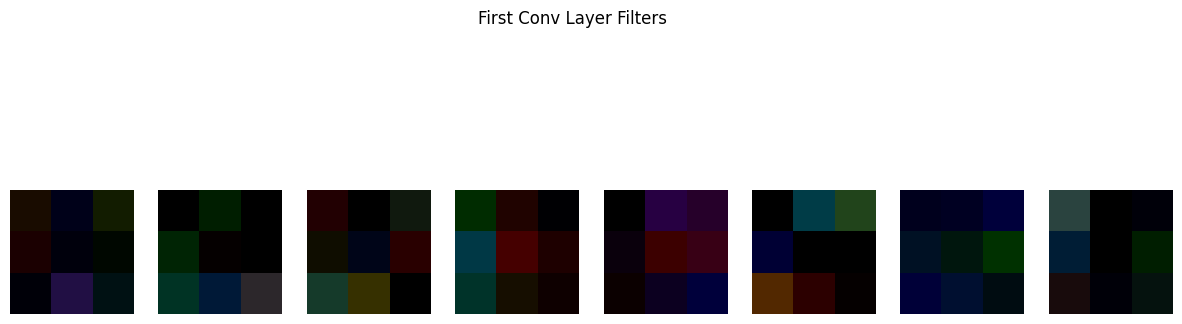

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


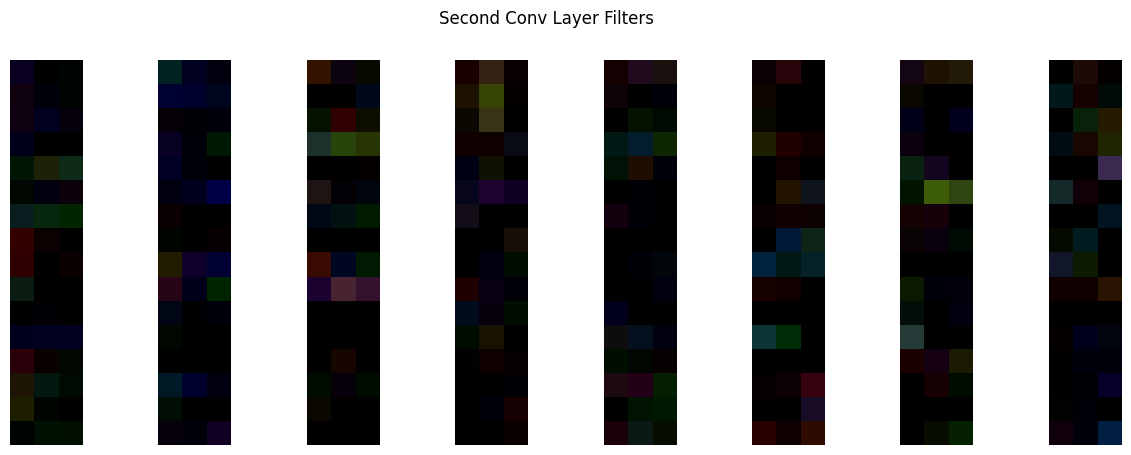

In [135]:
def visualize_filters(filters, num_filters=8, name="First"):
    filters = filters.detach().cpu()
    fig, axes = plt.subplots(1, num_filters, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= filters.size(0): break
        ax.imshow(filters[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.suptitle(f"{name} Conv Layer Filters")
    plt.show()

visualize_filters(cnn_model.conv1.weight, num_filters=8, name="First")
visualize_filters(cnn_model.conv2.weight, num_filters=8, name="Second")

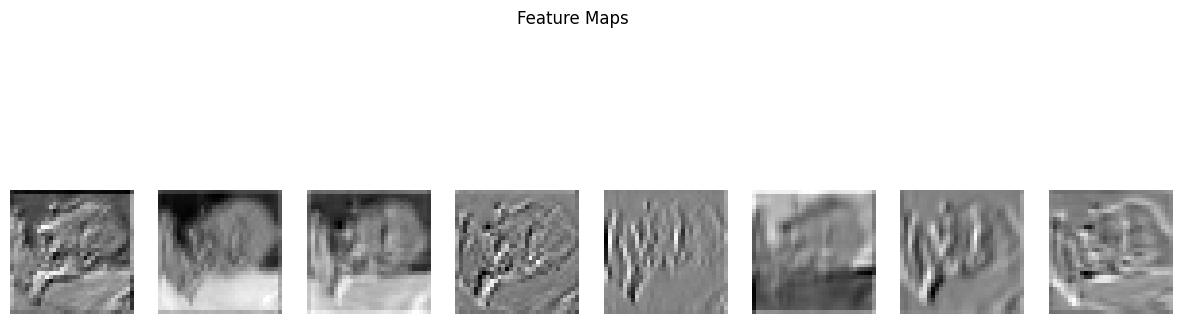

In [136]:
with torch.no_grad():
    conv1_output = cnn_model.conv1(next(iter(test_loader))[0].to("cuda"))

def visualize_feature_maps(feature_maps, num_maps=8):
    feature_maps = feature_maps.squeeze().detach().cpu()[0,:,:,:] 
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    for i, ax in enumerate(axes):
        if i >= feature_maps.size(0): break
        ax.imshow(feature_maps[i], cmap='gray')
        ax.axis('off')
    plt.suptitle("Feature Maps")
    plt.show()

visualize_feature_maps(conv1_output, num_maps=8)

## Compare the results [9 pts]

In this part, you will compare the results of both methods. While answering the questions below, consider the following points:

- What are the advantages and disadvantages of these models?
- In what scenarios would you use a CNN versus a custom ResNet?
- Is early stopping necessary during training? If so, why?
    
Also, feel free to use any library you want.

## COMMENTS
Advantages of CNN: Easier to implement, faster training.
Advantages of ResNet: Fast convergence, better performance, better generalization.

Disadvantages of CNN: Limited performance, poor generalization.
Disadvantages of ResNet: Higher computational cost, training time, complexity.

For simple applications we can use CNN. Also if we have limited harware we can use CNN. However if we have high computation resource and complex task we can use ResNet.

Early stopping is neccessary especially while using ResNet since the after some time training converges after that we dont need to spend resource. It also prevents overfitting.


#### Plot loss and accuracy curves per training epoch for both train and test sets. Make sure you put legend and labels. Comment on the results. [3 pts]

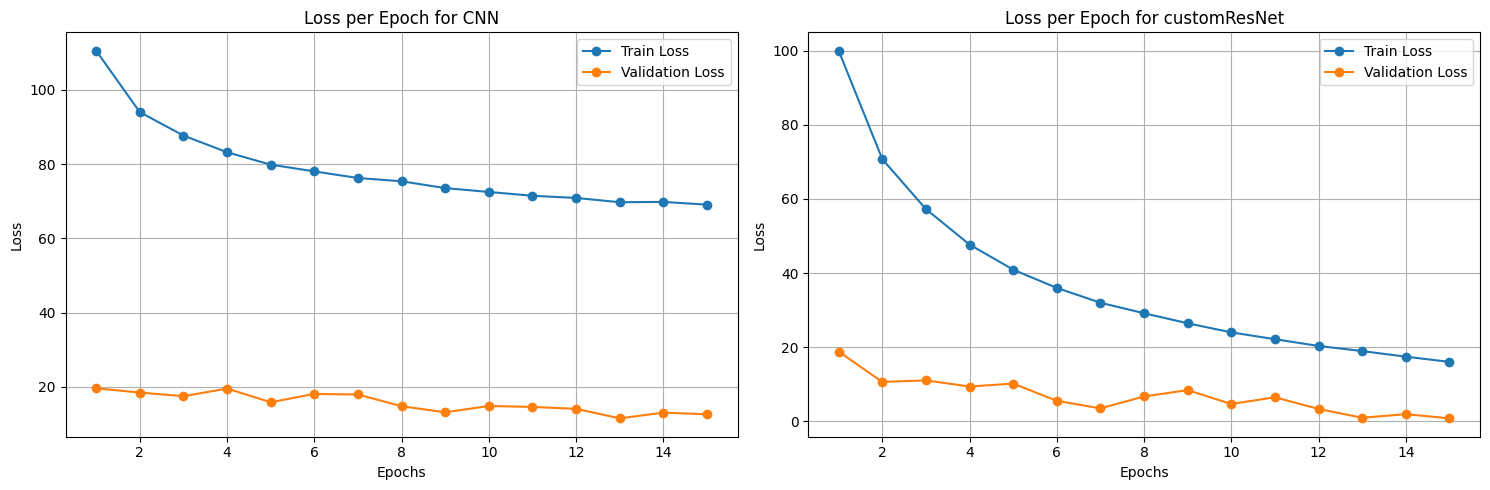

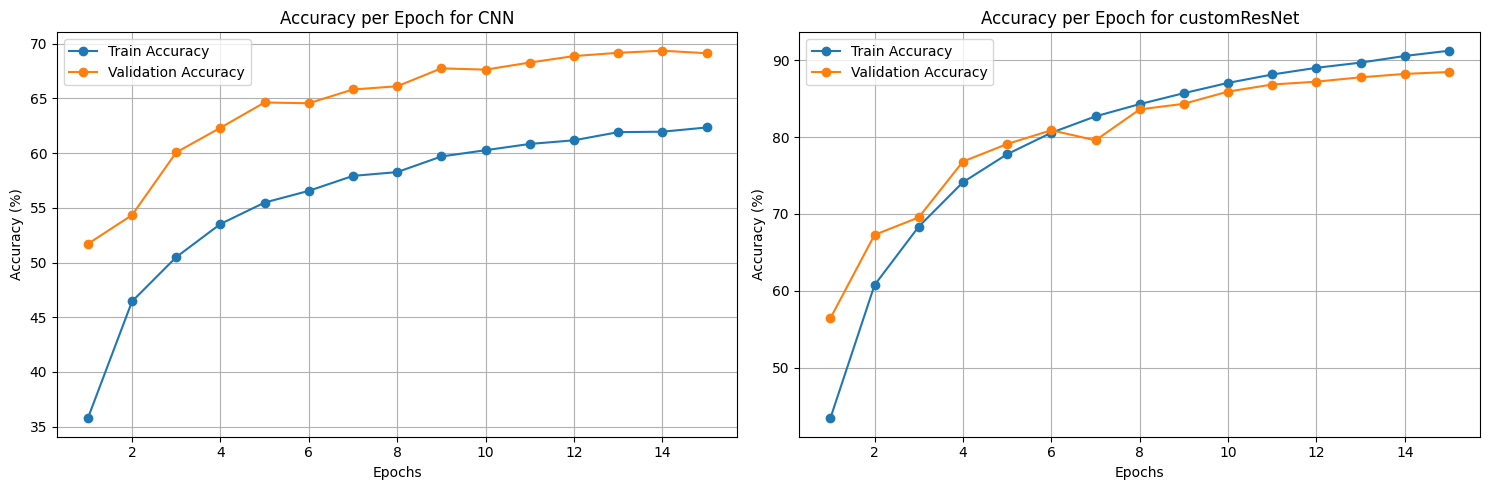

In [138]:
train_results = pd.read_csv('./outputs/train_results.csv')
validation_results = pd.read_csv('./outputs/validation_results.csv')

models = train_results['Model'].unique()

num_models = len(models)
rows = (num_models + 1) // 2

fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 5))
axs = axs.flatten()

for i, model in enumerate(models):
    train_model_data = train_results[train_results['Model'] == model]
    validation_model_data = validation_results[validation_results['Model'] == model]

    axs[i].plot(train_model_data['epoch'], train_model_data['loss'], label='Train Loss', marker='o')
    axs[i].plot(validation_model_data['epoch'], validation_model_data['loss'], label='Validation Loss', marker='o')
    axs[i].set_title(f'Loss per Epoch for {model}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(rows, 2, figsize=(15, rows * 5))
axs = axs.flatten()

for i, model in enumerate(models):
    train_model_data = train_results[train_results['Model'] == model]
    validation_model_data = validation_results[validation_results['Model'] == model]

    axs[i].plot(train_model_data['epoch'], train_model_data['accuracy'], label='Train Accuracy', marker='o')
    axs[i].plot(validation_model_data['epoch'], validation_model_data['accuracy'], label='Validation Accuracy', marker='o')
    axs[i].set_title(f'Accuracy per Epoch for {model}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Accuracy (%)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()




#### Visualize a few example test outputs with true and predicted labels (both models). Make comments [3 pts]

## COMMENTS
We can clearly say that the ResNet showed better performance as compared with CNN. However, we see that both models bad at predicting some labels such as 5. When we inspect them carefully, we can easily say that the examples with labeled as 5 are more hard to detect.

Files already downloaded and verified
Files already downloaded and verified


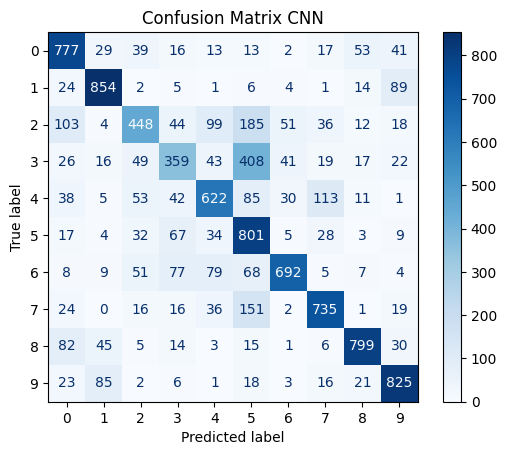

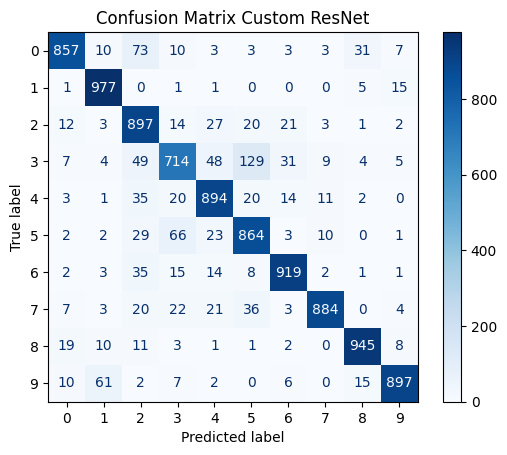

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np
import torch


def draw_cm(network, test_loader, device="cpu", model_name="CNN"):    
    network.eval()  
    all_targets = []
    all_predictions = []

    with torch.no_grad():  
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = network(inputs)

            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())



    cm = confusion_matrix(all_targets, all_predictions)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix {model_name}")
    plt.show()


train_loader, test_loader = fetch_dataloader()

draw_cm(cnn_model, test_loader, "cuda", "CNN")
draw_cm(custom_resnet_model, test_loader, "cuda", "Custom ResNet")


Both models are bad at predicting label 5 lets see some examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


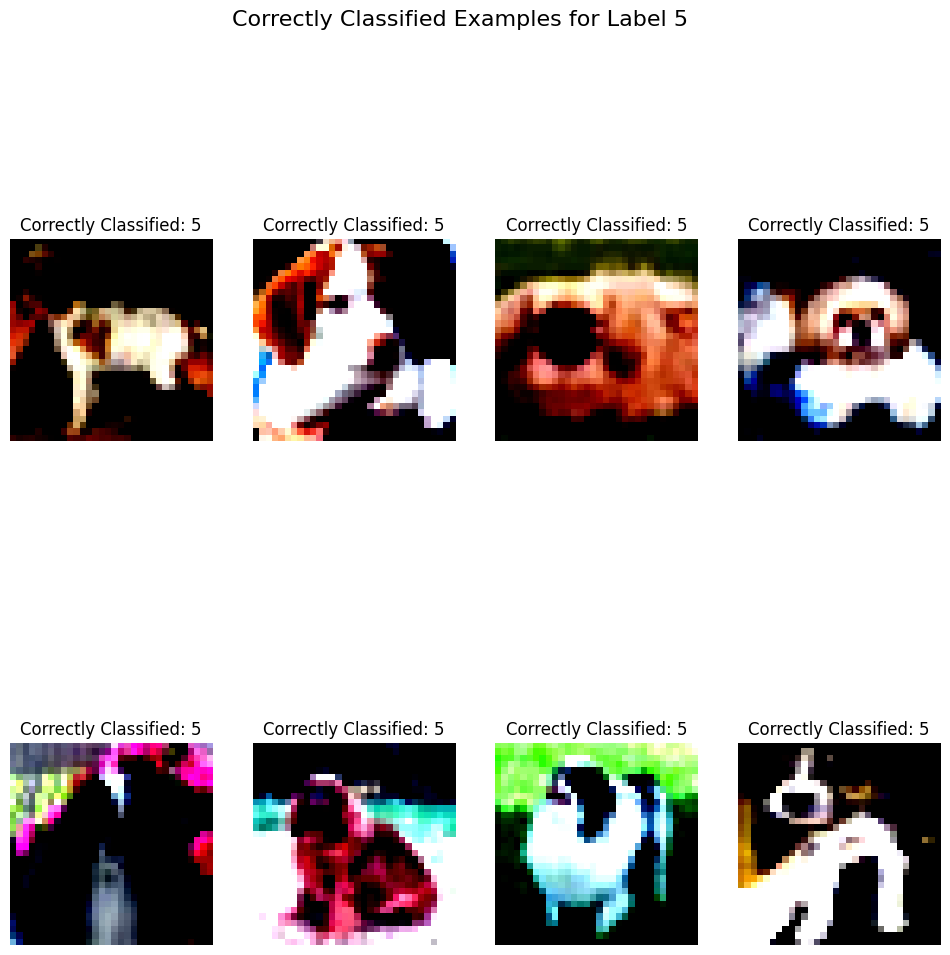

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


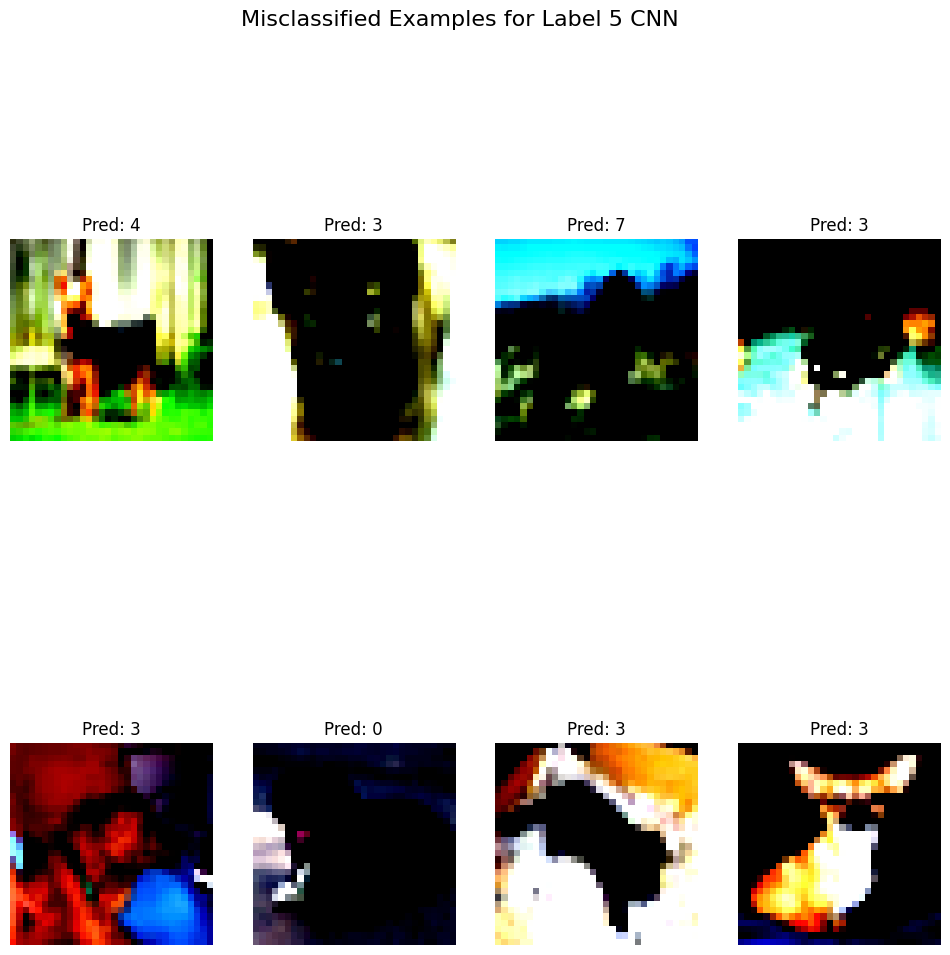

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


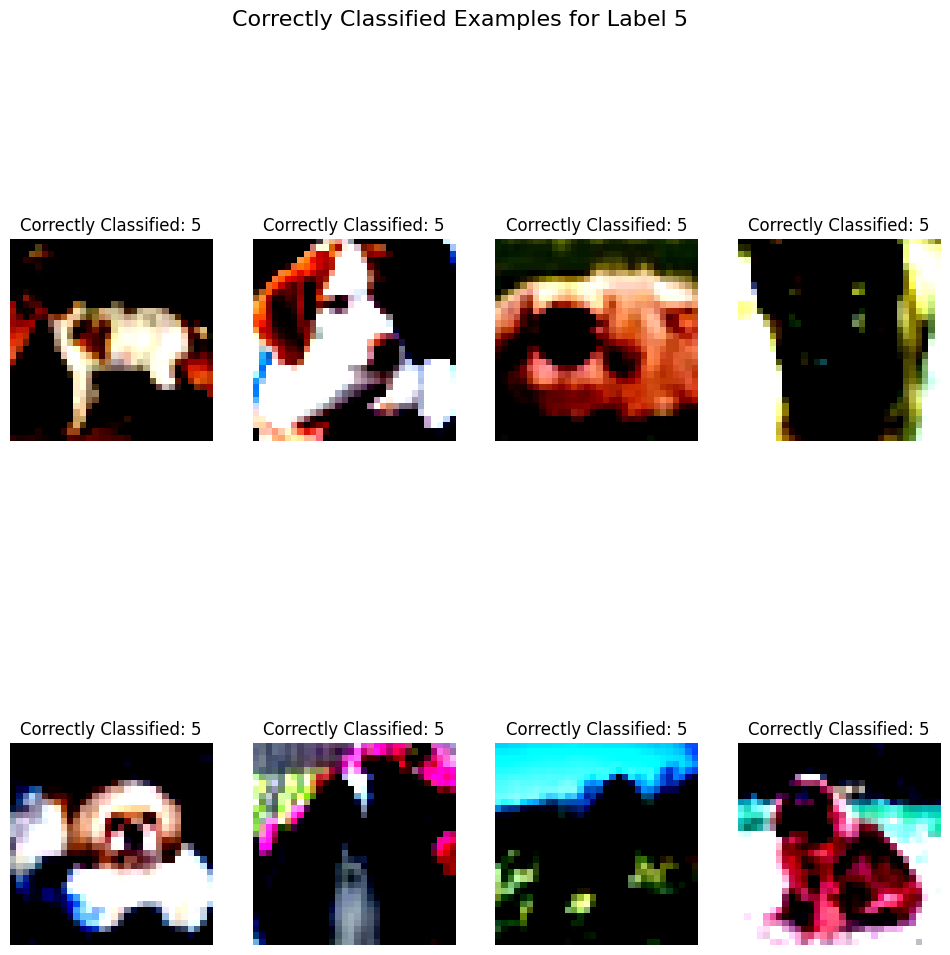

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


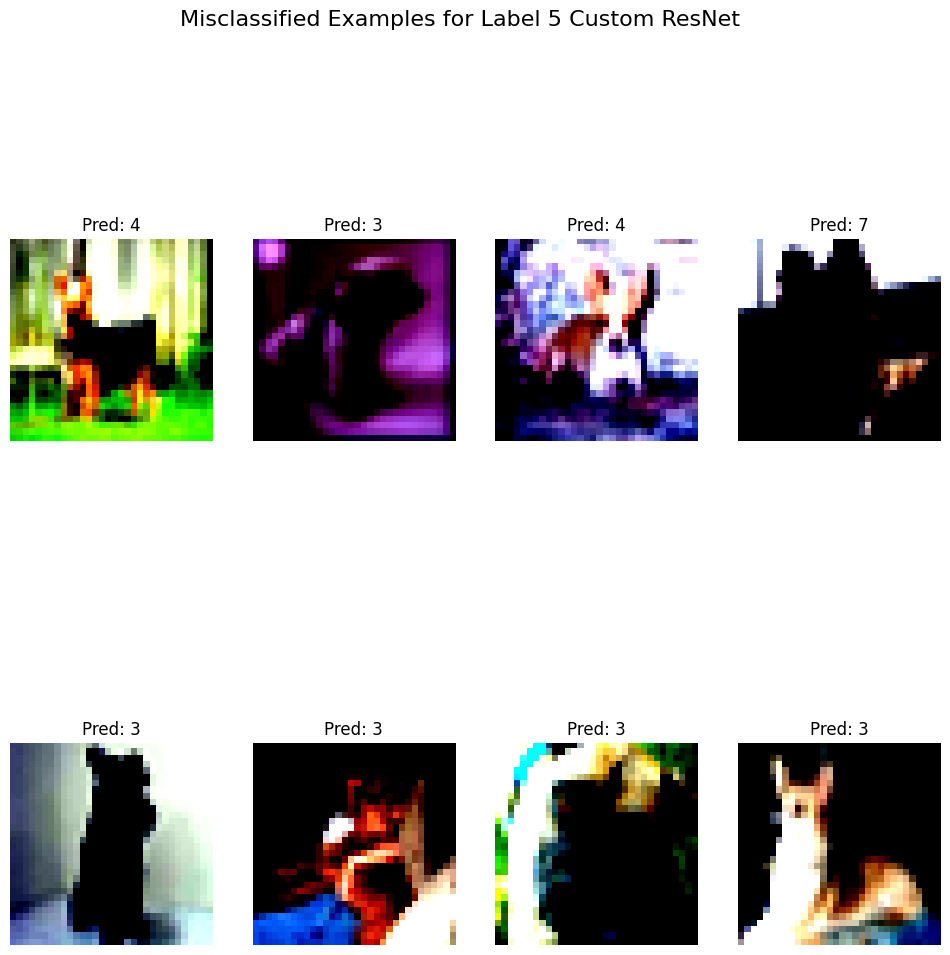

In [140]:
def visualize_classifications_for_label(network, test_loader, target_label=5, device="cpu", model_name="CNN"):
    network.eval()  
    true_classified_images = []
    misclassified_images = []
    misclassified_preds = []

    with torch.no_grad():  
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = network(inputs)
            _, predicted = torch.max(outputs, 1)

            true_classified_indices = (targets == target_label) & (predicted == target_label)
            misclassified_indices = (targets == target_label) & (predicted != target_label)

            true_classified_images.extend(inputs[true_classified_indices].cpu())
            misclassified_images.extend(inputs[misclassified_indices].cpu())
            misclassified_preds.extend(predicted[misclassified_indices].cpu().numpy())

    if true_classified_images:
        plt.figure(figsize=(12, 12))
        for i in range(min(8, len(true_classified_images))):  
            plt.subplot(2, 4, i + 1)
            img = true_classified_images[i]
            
            if img.shape[0] == 3:  
                img = img.permute(1, 2, 0)
                plt.imshow(img.numpy())
            else: 
                plt.imshow(img.squeeze().numpy(), cmap='gray')
            
            plt.title(f"Correctly Classified: {target_label}")
            plt.axis('off')
        plt.suptitle(f"Correctly Classified Examples for Label {target_label}", fontsize=16)
        plt.show()

    if misclassified_images:
        plt.figure(figsize=(12, 12))
        for i in range(min(8, len(misclassified_images))): 
            plt.subplot(2, 4, i + 1)
            img = misclassified_images[i]
            
            if img.shape[0] == 3:  
                img = img.permute(1, 2, 0)
                plt.imshow(img.numpy())
            else:  # If grayscale
                plt.imshow(img.squeeze().numpy(), cmap='gray')
            
            plt.title(f"Pred: {misclassified_preds[i]}")
            plt.axis('off')
        plt.suptitle(f"Misclassified Examples for Label {target_label} {model_name}", fontsize=16)
        plt.show()
    else:
        print(f"No misclassified examples found for label {target_label} {model_name}.")
        
visualize_classifications_for_label(
    network=cnn_model,
    test_loader=test_loader,
    target_label=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="CNN"
)

visualize_classifications_for_label(
    network=custom_resnet_model,
    test_loader=test_loader,
    target_label=5,
    device="cuda" if torch.cuda.is_available() else "cpu",
    model_name="Custom ResNet"
)

#### Compare number of parameters of the models. Comment your insights [3 pts]

## COMMENTS
As we expected the ResNet has much more parameters that makes it more accurate and faster to converge. However, this causes the need for more computational power.

In [141]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    "CNN": cnn_model,  
    "ResNet": custom_resnet_model,  
}

for name, model in models.items():
    param_count = count_parameters(model)
    print(f"Model: {name}, Parameters: {param_count:,}")


Model: CNN, Parameters: 268,650
Model: ResNet, Parameters: 4,732,298


# PART IV Object Detection [28 pts]

Object detection is a computer vision task where the goal is to identify and localize objects within an image. 
Unlike image classification, where the focus is on assigning a single label to an image, object detection involves:
- Predicting **what** objects are present (class labels).
- Predicting **where** the objects are located (bounding boxes).

#### Image Classification vs Object Detection:

Image classification answers the question: **What is in the image?**

Object detection answers the questions: **What objects are in the image, and where are they located?**

#### Why Object Detection?
Object detection is used in a variety of real-world applications, such as:
- **Autonomous vehicles**: Detecting pedestrians, vehicles, and traffic signs.
- **Medical imaging**: Identifying abnormalities in scans (e.g., tumors).
- **Surveillance**: Recognizing and tracking people or objects in video feeds.
- **Retail**: Counting products or monitoring shelves.


#### Components of Object Detection:

A basic object detection network typically consists of two outputs:
1. **Class Prediction**: A probability distribution over possible object classes.
2. **Bounding Box Regression**: Coordinates of the bounding box enclosing the object.


- The bounding box is represented as `[x_min, y_min, x_max, y_max]`, where:
  - `(x_min, y_min)` is the top-left corner.
  - `(x_max, y_max)` is the bottom-right corner.
- The network predicts both **what** (class label) and **where** (bounding box coordinates).

### Define a Basic Object Detection Network
The network should:
- Take an image as input.
- Output a class label and four bounding box coordinates.

**Hints**:
- The final layer should output both the class probabilities and bounding box coordinates.
- Use the CNN you trained in the previous part as the backbone of your object detector. Add two heads to your backbone model, where one of the heads will predict the object class and the other will predict the object location. 


**Steps**:
- Implement a network that consists of a backbone and two heads.
- Build forward and backward propagation for the network.
- Use separate loss functions for classification (cross-entropy) and bounding box regression (mean squared error).
- Train the network on the object detection dataset.


### Dataset

You will detect license plates:
https://ieee-dataport.org/open-access/cd-lp-compressed-domain-license-plate-detection-database

The dataset contains 2,400 vehicle images for license plate detection purposes. There are 3 subsets, where you'll use only pixel domain images (2400 images). Since you'll predict the license plate coordinates, number of classes will be 2 (plate and non-plate objects). 

In [142]:
import zipfile
import os

if not os.path.exists("/teamspace/studios/this_studio/BGL561E-HW2/data/DB"):
    zip_file_path = "/teamspace/studios/this_studio/DB.ZIP"
    extract_to = "/teamspace/studios/this_studio/BGL561E-HW2/data"

    os.makedirs(extract_to, exist_ok=True)

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    print(f"Files extracted to {extract_to}")
else: 
    print("Data already extracted")


Data already extracted


In [143]:
import os

def find_background_images(path_to_txt_files, path_to_images):
    background_images = []

    for image_file in os.listdir(path_to_images):
        base_name, _ = os.path.splitext(image_file)
        txt_file_path = os.path.join(path_to_txt_files, f"{base_name}.txt")

        res = 0
        if os.path.exists(txt_file_path):
            with open(txt_file_path, "r") as txt_file:
                content = txt_file.read().strip()
                res += int(content[0])
                if not content:
                    background_images.append(image_file)
        else:
            background_images.append(image_file)
    print(res)
    return background_images

txt_files_path = "/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Train"
images_path = "/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Train"

background_images = find_background_images(txt_files_path, images_path)

print(f"Background Images ({len(background_images)}):")
for bg_image in background_images:
    print(bg_image)


0
Background Images (0):


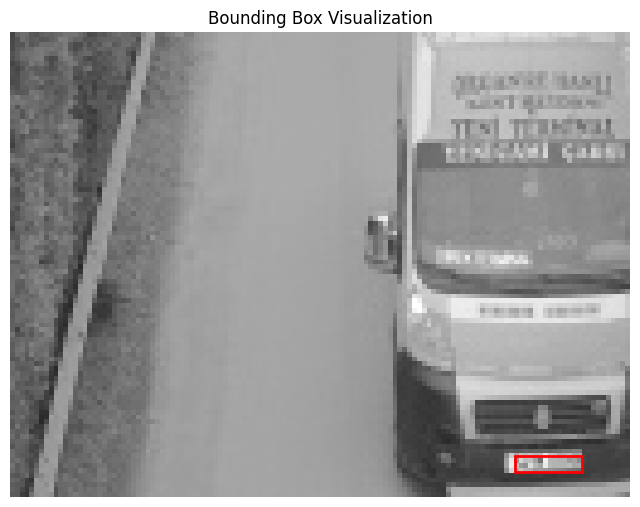

In [144]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_image_with_bbox(image_path, annotation_path):
    image = Image.open(image_path)
    img_width, img_height = image.size

    bboxes = []
    with open(annotation_path, "r") as f:
        for line in f:
            data = line.strip().split()
            class_id = int(data[0])  
            x_center, y_center, width, height = map(float, data[1:])
            
            x_min = (x_center - width / 2) * img_width
            y_min = (y_center - height / 2) * img_height
            x_max = (x_center + width / 2) * img_width
            y_max = (y_center + height / 2) * img_height
            
            bboxes.append([x_min, y_min, x_max, y_max])

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle(
            (x_min, y_min),  
            x_max - x_min,   
            y_max - y_min,   
            linewidth=2,
            edgecolor="r",
            facecolor="none"
        )
        ax.add_patch(rect)

    ax.set_title(f"Bounding Box Visualization")
    plt.axis("off")
    plt.show()

image_path = "/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Test/101801.jpg"  
annotation_path = "/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Test/101801.txt"  

visualize_image_with_bbox(image_path, annotation_path)


#### Implement the network [10 pts]

In [145]:
import torch.nn as nn
import torch

class ObjectDetectionNetwork(nn.Module):
    def __init__(self, backbone=CNN()):
        super(ObjectDetectionNetwork, self).__init__()
        
        self.backbone = backbone
        
        self.cls_head = nn.Linear(10, 2)  # Plate, non-plate
        
        self.reg_head = nn.Linear(10, 4)  # [x_min, y_min, x_max, y_max]
    
    def forward(self, x):
        x = self.backbone(x)

        class_logits = self.cls_head(x)
        
        bbox_coordinates = self.reg_head(x)
        
        return class_logits, bbox_coordinates


#### Train the network [5 pts]

In [146]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  
                image_path = os.path.join(root_dir, filename)
                label_path = os.path.splitext(image_path)[0] + ".txt"  
                if os.path.exists(label_path):
                    self.data.append((image_path, label_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label_path = self.data[idx]
        
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        with open(label_path, "r") as f:
            annotation = f.readline().strip()
            label_data = list(map(float, annotation.split()))  
        
        label_class = int(label_data[0]) 
        bbox = torch.tensor(label_data[1:])  

        return image, label_class, bbox


def fetch_dataloader():
    train_transformer = transforms.Compose([
            transforms.Resize((32, 32)),            # Resize to 32x32
            transforms.RandomHorizontalFlip(),  
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]
                                           )

    dev_transformer = transforms.Compose([
        transforms.Resize((32, 32)),            # Resize to 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    # ************************************************************************************
    trainset = CustomDataset(root_dir='/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Train', transform=train_transformer)
    devset =  CustomDataset(root_dir='/teamspace/studios/this_studio/BGL561E-HW2/data/DB/PixelDomain/Test', transform=dev_transformer)

    
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    devloader = DataLoader(devset, batch_size=64, shuffle=False, num_workers=2)
    
    for images, labels, bboxes in trainloader:
        print("Image batch shape:", images.shape)
        print("Label batch shape:", labels.shape)
        print("BBox batch shape:", bboxes.shape)
        break
    
    return trainloader, devloader


In [147]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

def save_model(model, filename):
    filepath = f"./outputs/{filename}.pkl"
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")
    
def train(network, optimizer, loss_fn, train_loader, epochs, verbose=True, device="cpu", test_loader=None):
    network = network.to(device)
    train_data = []

    for epoch in range(epochs):
        network.train()
        total_cls_loss = 0.0
        total_reg_loss = 0.0

        for images, labels, bboxes in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            class_logits, bbox_coordinates = network(images)

            cls_loss = loss_fn["cls_loss_fn"](class_logits, labels)
            reg_loss = loss_fn["reg_loss_fn"](bbox_coordinates, bboxes)

            total_loss = cls_loss + reg_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_cls_loss += cls_loss.item()
            total_reg_loss += reg_loss.item()

        if verbose:
            print(f"Epoch [{epoch + 1}/{epochs}], Classification Loss: {total_cls_loss:.4f}, Regression Loss: {total_reg_loss:.4f}")

        train_data.append((total_cls_loss, total_reg_loss))

    return network, train_data

def evalf(network, loader, device="cpu", loss_fn=None, iou_threshold=0.5):
    network.eval()
    correct = 0
    total = 0
    total_cls_loss = 0.0
    total_reg_loss = 0.0

    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, labels, bboxes in loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            

            class_logits, bbox_coordinates = network(images)

            _, predicted = torch.max(class_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if loss_fn:
                cls_loss = loss_fn["cls_loss_fn"](class_logits, labels)
                reg_loss = loss_fn["reg_loss_fn"](bbox_coordinates, bboxes)
                total_cls_loss += cls_loss.item()
                total_reg_loss += reg_loss.item()

            pred_classes = predicted.to("cpu").numpy()
            pred_bboxes = bbox_coordinates.to("cpu").numpy()
            gt_classes = labels.to("cpu").numpy()
            gt_bboxes = bboxes.to("cpu").numpy()

            for i in range(len(pred_classes)):
                predictions.append(
                    [
                        pred_bboxes[i][0], pred_bboxes[i][1],  # x_min, y_min
                        pred_bboxes[i][2], pred_bboxes[i][3],  # x_max, y_max
                        "car" if pred_classes[i] == 0 else "non-car",  # Map class to string
                    ]
                )

                ground_truths.append(
                    [
                        gt_bboxes[i][0], gt_bboxes[i][1],  # x_min, y_min
                        gt_bboxes[i][2], gt_bboxes[i][3],  # x_max, y_max
                        "car" if gt_classes[i] == 0 else "non-car",  # Map class to string
                    ]
                )

    accuracy = correct / total

    print(f"Validation | Accuracy: {accuracy:.4f}, Classification Loss: {total_cls_loss:.4f}, Regression Loss: {total_reg_loss:.4f}")
    
    return accuracy, (total_cls_loss, total_reg_loss), (predictions, ground_truths)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = fetch_dataloader()

network = ObjectDetectionNetwork(backbone=CNN()).to(device)

optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_fn = {
    "cls_loss_fn": nn.CrossEntropyLoss(),  
    "reg_loss_fn": nn.MSELoss()  
}

print("Training ObjectDetectionNetwork...")
network, train_data = train(
    network, optimizer, loss_fn, train_loader, epochs=500, verbose=True, device=device
)

save_model(network, "ObjectDetectionNetwork")

accuracy, _, results = evalf(network, test_loader, device=device, loss_fn=loss_fn)
print(f"Final Accuracy: {accuracy:.5f}")


Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])
BBox batch shape: torch.Size([64, 4])
Training ObjectDetectionNetwork...
Epoch [1/500], Classification Loss: 7.1467, Regression Loss: 6.2119
Epoch [2/500], Classification Loss: 0.6428, Regression Loss: 1.7456
Epoch [3/500], Classification Loss: 0.1942, Regression Loss: 1.0727
Epoch [4/500], Classification Loss: 0.1087, Regression Loss: 0.8628
Epoch [5/500], Classification Loss: 0.0465, Regression Loss: 0.7917
Epoch [6/500], Classification Loss: 0.0492, Regression Loss: 0.7151
Epoch [7/500], Classification Loss: 0.0363, Regression Loss: 0.7003
Epoch [8/500], Classification Loss: 0.0261, Regression Loss: 0.6350
Epoch [9/500], Classification Loss: 0.0255, Regression Loss: 0.6221
Epoch [10/500], Classification Loss: 0.0248, Regression Loss: 0.6014
Epoch [11/500], Classification Loss: 0.0190, Regression Loss: 0.5982
Epoch [12/500], Classification Loss: 0.0227, Regression Loss: 0.5855
Epoch [13/500], Classific

#### Evaluate the model and plot precision, recall, and mAP scores for different IoU thresholds [5 pts]

Evaluate the network using **evaluate()** below for different IoU thresholds [0.1; 0.1; 1]:



In [148]:

import numpy as np

def convert_bboxes(predictions, ground_truths, img_width, img_height):
    converted_predictions = []
    converted_ground_truths = []

    # Convert predictions
    for prediction in predictions:
        pred_bbox = [
            (prediction[0] - prediction[2] / 2) * img_width,  # x_min
            (prediction[1] - prediction[3] / 2) * img_height, # y_min
            (prediction[0] + prediction[2] / 2) * img_width,  # x_max
            (prediction[1] + prediction[3] / 2) * img_height, # y_max
            prediction[4]  # class
        ]
        converted_predictions.append(pred_bbox)

    # Convert ground truths
    for ground_truth in ground_truths:
        gt_bbox = [
            (ground_truth[0] - ground_truth[2] / 2) * img_width,  # x_min
            (ground_truth[1] - ground_truth[3] / 2) * img_height, # y_min
            (ground_truth[0] + ground_truth[2] / 2) * img_width,  # x_max
            (ground_truth[1] + ground_truth[3] / 2) * img_height, # y_max
            ground_truth[4]  # class
        ]
        converted_ground_truths.append(gt_bbox)

    return converted_predictions, converted_ground_truths

def calculate_iou(pred_box, gt_box):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    Args:
        pred_box (list): [x_min, y_min, x_max, y_max] for the predicted box.
        gt_box (list): [x_min, y_min, x_max, y_max] for the ground truth box.
    Returns:
        float: IoU value.
    """
    # Compute intersection
    x_min_inter = max(pred_box[0], gt_box[0])
    y_min_inter = max(pred_box[1], gt_box[1])
    x_max_inter = min(pred_box[2], gt_box[2])
    y_max_inter = min(pred_box[3], gt_box[3])

    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter) 
    
    # Compute union
    pred_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    union_area = pred_area + gt_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def evaluate(predictions, ground_truths, iou_threshold=0.5):
    """
    Evaluate object detection metrics: Precision, Recall, and mAP.
    Args:
        predictions (list): List of predicted bounding boxes [[x_min, y_min, x_max, y_max, class], ...].
        ground_truths (list): List of ground truth boxes [[x_min, y_min, x_max, y_max, class], ...].
        iou_threshold (float): IoU threshold to consider a prediction correct.
    Returns:
        dict: Precision, Recall, and mAP scores.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    matched_gt = set()  # Keep track of matched ground truths

    for pred in predictions:
        pred_box, pred_class = pred[:4], pred[4]
        max_iou = 0
        matched = None

        for i, gt in enumerate(ground_truths):
            gt_box, gt_class = gt[:4], gt[4]

            # Only consider matching predictions of the same class
            if pred_class == gt_class:
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou and iou >= iou_threshold and i not in matched_gt:
                    max_iou = iou
                    matched = i

        if matched is not None:
            tp += 1
            matched_gt.add(matched)
        else:
            fp += 1
    
    # fn = len(ground_truths) - len(matched_gt)
    fn = 0  # In our dataset there is no background image. That makes the fn 0

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    # For simplicity, mAP can be computed as Precision in this example
    # In real scenarios, mAP requires averaging precision at multiple recall thresholds
    mAP = precision
    
    print(f"IOU TH: {iou_threshold} TP: {tp} FP: {fp} FN: {fn}")
    return {"Precision": precision, "Recall": recall, "mAP": mAP}

predictions = results[0]
ground_truths = results[1]

predictions, ground_truths = convert_bboxes(predictions, ground_truths, 32, 32)
# Evaluate
res = evaluate(predictions, ground_truths, iou_threshold=0.5)
print("Evaluation Results:")
print(res)


IOU TH: 0.5 TP: 322 FP: 278 FN: 0
Evaluation Results:
{'Precision': 0.5366666666666666, 'Recall': 1.0, 'mAP': 0.5366666666666666}


IOU TH: 0.1 TP: 438 FP: 162 FN: 0
IOU TH: 0.2 TP: 411 FP: 189 FN: 0
IOU TH: 0.30000000000000004 TP: 395 FP: 205 FN: 0
IOU TH: 0.4 TP: 353 FP: 247 FN: 0
IOU TH: 0.5 TP: 322 FP: 278 FN: 0
IOU TH: 0.6 TP: 265 FP: 335 FN: 0
IOU TH: 0.7000000000000001 TP: 179 FP: 421 FN: 0
IOU TH: 0.8 TP: 84 FP: 516 FN: 0
IOU TH: 0.9 TP: 11 FP: 589 FN: 0


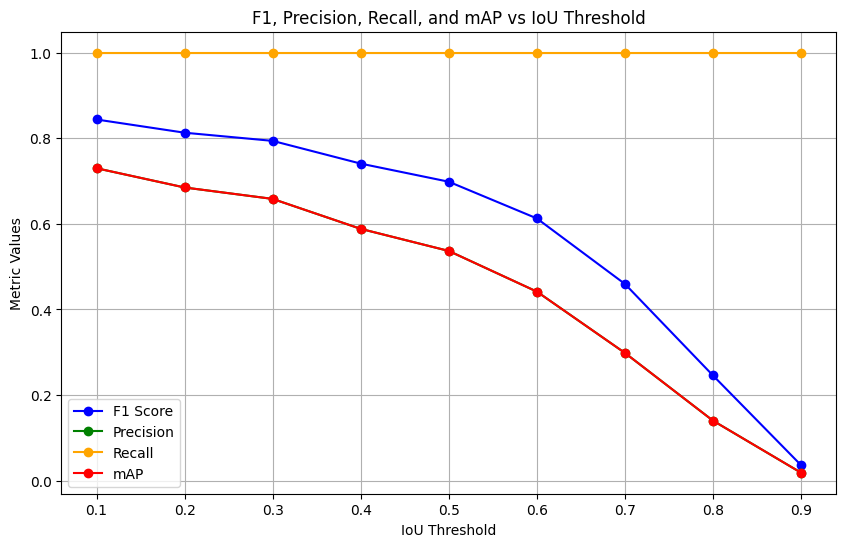

In [149]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_f1(precision, recall):
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def plot_metrics_curves(predictions, ground_truths):
    iou_thresholds = np.linspace(0.1, 0.9, 9)  
    f1_scores = []  
    precisions = [] 
    recalls = [] 
    mAPs = []  

    for iou_threshold in iou_thresholds:
        r = evaluate(predictions, ground_truths, iou_threshold=iou_threshold)
        precision = r["Precision"]
        recall = r["Recall"]
        mAP = r["mAP"]

        precisions.append(precision)
        recalls.append(recall)
        mAPs.append(mAP)
        
        f1 = calculate_f1(precision, recall)
        f1_scores.append(f1)

    plt.figure(figsize=(10, 6))
    plt.plot(iou_thresholds, f1_scores, marker="o", label="F1 Score", color="blue")
    plt.plot(iou_thresholds, precisions, marker="o", label="Precision", color="green")
    plt.plot(iou_thresholds, recalls, marker="o", label="Recall", color="orange")
    plt.plot(iou_thresholds, mAPs, marker="o", label="mAP", color="red")

    plt.xlabel("IoU Threshold")
    plt.ylabel("Metric Values")
    plt.title("F1, Precision, Recall, and mAP vs IoU Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_metrics_curves(predictions, ground_truths)

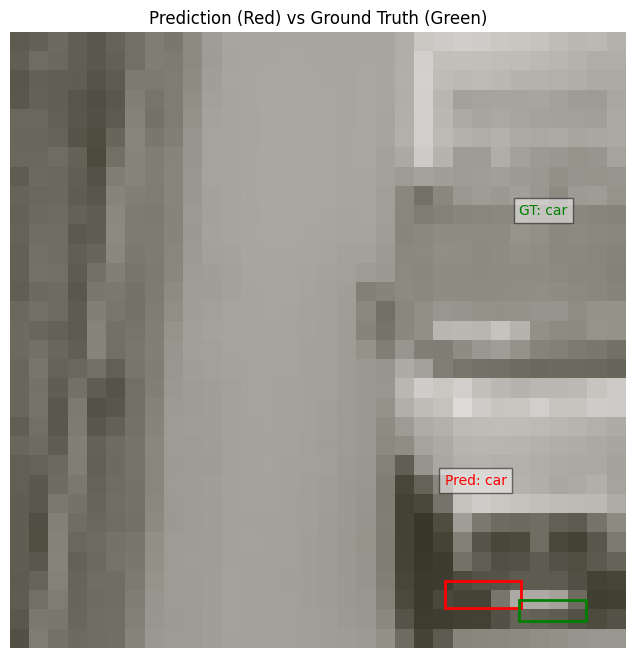

In [150]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as transforms

def visualize_single_image_with_bbox(image_tensor, prediction, ground_truth, img_width, img_height):
    pred_bbox = prediction
    gt_bbox = ground_truth

    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)
    image_tensor = image_tensor * std + mean  # Undo normalization
    image_np = image_tensor.permute(1, 2, 0).numpy().clip(0, 1)

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    rect_pred = patches.Rectangle(
        (pred_bbox[0], pred_bbox[1]),  # (x_min, y_min)
        pred_bbox[2] - pred_bbox[0],  # width
        pred_bbox[3] - pred_bbox[1],  # height
        linewidth=2, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect_pred)
    ax.text(pred_bbox[0], pred_bbox[1] - 5, f"Pred: {prediction[-1]}", color="r", fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

    rect_gt = patches.Rectangle(
        (gt_bbox[0], gt_bbox[1]),  # (x_min, y_min)
        gt_bbox[2] - gt_bbox[0],  # width
        gt_bbox[3] - gt_bbox[1],  # height
        linewidth=2, edgecolor="g", facecolor="none"
    )
    ax.add_patch(rect_gt)
    ax.text(gt_bbox[0], gt_bbox[1] - 20, f"GT: {ground_truth[-1]}", color="g", fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

    ax.set_title("Prediction (Red) vs Ground Truth (Green)")
    plt.axis("off")
    plt.show()

    
images, labels, bboxes = next(iter(test_loader))

visualize_single_image_with_bbox(images[0][0], predictions[0], ground_truths[0], 32, 32)

### Comparison [8 pts]
Try different backbones: the Resnet you trained and an untrained (only initialized) CNN.
Do backbones with different architectures affect the object detection performance?

Compare the pretrained and untrained backbones: Do pretrained backbones ease object detection, in your experiments? If not, why?

## COMMENTS
I got the best result with the pretrained custom ResNet after and custom resnet from scratch training was performed similary. After that i got better results for from scratch training with CNN as compared the pretrained CNN. 
As a result since the ResNet can learn genrable features using ResNet as backbone improved peformance and reduced training time. Using pretrained proper backbones improves the object detection performance.

### Pretrained CNN backbone 250 epochs

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])
BBox batch shape: torch.Size([64, 4])
Training ObjectDetectionNetwork...
Epoch [1/250], Classification Loss: 19.7264, Regression Loss: 15.7584
Epoch [2/250], Classification Loss: 2.8639, Regression Loss: 5.1616
Epoch [3/250], Classification Loss: 0.6606, Regression Loss: 2.3929
Epoch [4/250], Classification Loss: 0.2192, Regression Loss: 1.6046
Epoch [5/250], Classification Loss: 0.1245, Regression Loss: 1.3093
Epoch [6/250], Classification Loss: 0.0906, Regression Loss: 1.2355
Epoch [7/250], Classification Loss: 0.0495, Regression Loss: 1.1321
Epoch [8/250], Classification Loss: 0.0418, Regression Loss: 1.0268
Epoch [9/250], Classification Loss: 0.0387, Regression Loss: 0.9890
Epoch [10/250], Classification Loss: 0.0216, Regression Loss: 0.8983
Epoch [11/250], Classification Loss: 0.0274, Regression Loss: 0.9256
Epoch [12/250], Classification Loss: 0.0380, Regression Loss: 0.8183
Epoch [13/250], Classif

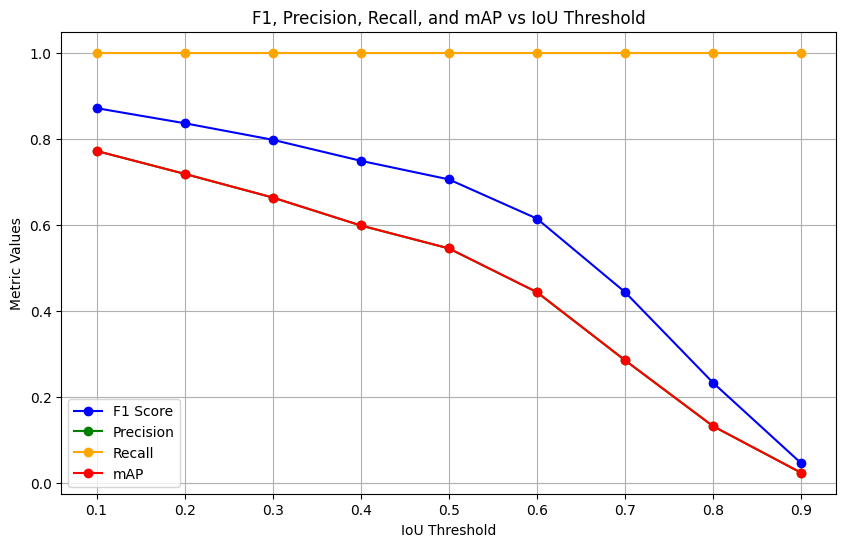

In [99]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = fetch_dataloader()

network = ObjectDetectionNetwork(backbone=cnn_model).to(device)

optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_fn = {
    "cls_loss_fn": nn.CrossEntropyLoss(),  
    "reg_loss_fn": nn.MSELoss()  
}

print("Training ObjectDetectionNetwork...")
network, train_data = train(
    network, optimizer, loss_fn, train_loader, epochs=250, verbose=True, device=device
)

save_model(network, "ObjectDetectionNetwork")

accuracy, _, results = evalf(network, test_loader, device=device, loss_fn=loss_fn)
print(f"Final Accuracy: {accuracy:.5f}")

predictions = results[0]
ground_truths = results[1]

predictions, ground_truths = convert_bboxes(predictions, ground_truths, 32, 32)
# Evaluate
res = evaluate(predictions, ground_truths, iou_threshold=0.5)
print("Evaluation Results:")
print(res)

plot_metrics_curves(predictions, ground_truths)


### Pretrained Custom Resnet backbone 250 epochs

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])
BBox batch shape: torch.Size([64, 4])
Training ObjectDetectionNetwork...
Epoch [1/250], Classification Loss: 14.4073, Regression Loss: 23.5720
Epoch [2/250], Classification Loss: 0.3077, Regression Loss: 2.5245
Epoch [3/250], Classification Loss: 0.2332, Regression Loss: 1.5656
Epoch [4/250], Classification Loss: 0.1530, Regression Loss: 0.9849
Epoch [5/250], Classification Loss: 0.1141, Regression Loss: 0.7932
Epoch [6/250], Classification Loss: 0.0793, Regression Loss: 0.6677
Epoch [7/250], Classification Loss: 0.0602, Regression Loss: 0.5568
Epoch [8/250], Classification Loss: 0.0586, Regression Loss: 0.4529
Epoch [9/250], Classification Loss: 0.0454, Regression Loss: 0.4798
Epoch [10/250], Classification Loss: 0.0443, Regression Loss: 0.4035
Epoch [11/250], Classification Loss: 0.0345, Regression Loss: 0.3849
Epoch [12/250], Classification Loss: 0.0328, Regression Loss: 0.4046
Epoch [13/250], Classif

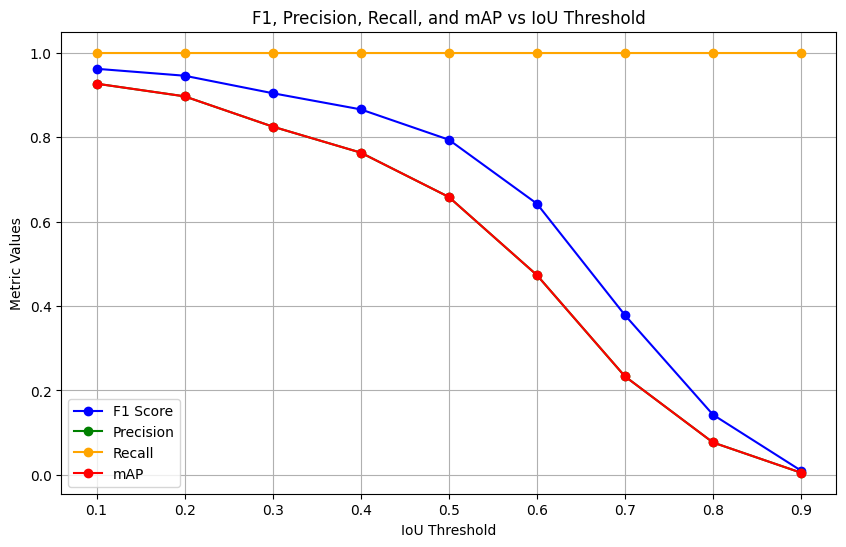

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = fetch_dataloader()

network = ObjectDetectionNetwork(backbone=custom_resnet_model).to(device)

optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_fn = {
    "cls_loss_fn": nn.CrossEntropyLoss(),  
    "reg_loss_fn": nn.MSELoss()  
}

print("Training ObjectDetectionNetwork...")
network, train_data = train(
    network, optimizer, loss_fn, train_loader, epochs=250, verbose=True, device=device
)

save_model(network, "ObjectDetectionNetwork")

accuracy, _, results = evalf(network, test_loader, device=device, loss_fn=loss_fn)
print(f"Final Accuracy: {accuracy:.5f}")

predictions = results[0]
ground_truths = results[1]

predictions, ground_truths = convert_bboxes(predictions, ground_truths, 32, 32)
# Evaluate
res = evaluate(predictions, ground_truths, iou_threshold=0.5)
print("Evaluation Results:")
print(res)

plot_metrics_curves(predictions, ground_truths)


### CNN backbone 250 epochs

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])
BBox batch shape: torch.Size([64, 4])
Training ObjectDetectionNetwork...
Epoch [1/250], Classification Loss: 2.7597, Regression Loss: 3.9415
Epoch [2/250], Classification Loss: 0.3396, Regression Loss: 1.4428
Epoch [3/250], Classification Loss: 0.1326, Regression Loss: 0.9672
Epoch [4/250], Classification Loss: 0.0614, Regression Loss: 0.7802
Epoch [5/250], Classification Loss: 0.0434, Regression Loss: 0.6952
Epoch [6/250], Classification Loss: 0.0266, Regression Loss: 0.6796
Epoch [7/250], Classification Loss: 0.0217, Regression Loss: 0.6429
Epoch [8/250], Classification Loss: 0.0146, Regression Loss: 0.6382
Epoch [9/250], Classification Loss: 0.0161, Regression Loss: 0.5808
Epoch [10/250], Classification Loss: 0.0143, Regression Loss: 0.6096
Epoch [11/250], Classification Loss: 0.0116, Regression Loss: 0.5574
Epoch [12/250], Classification Loss: 0.0139, Regression Loss: 0.5709
Epoch [13/250], Classific

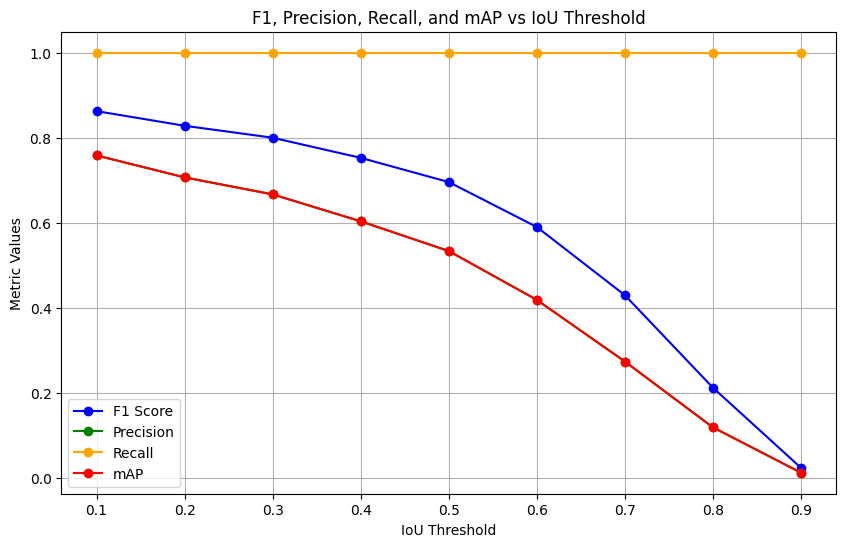

In [101]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = fetch_dataloader()

network = ObjectDetectionNetwork(backbone=CNN()).to(device)

optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_fn = {
    "cls_loss_fn": nn.CrossEntropyLoss(),  
    "reg_loss_fn": nn.MSELoss()  
}

print("Training ObjectDetectionNetwork...")
network, train_data = train(
    network, optimizer, loss_fn, train_loader, epochs=250, verbose=True, device=device
)

save_model(network, "ObjectDetectionNetwork")

accuracy, _, results = evalf(network, test_loader, device=device, loss_fn=loss_fn)
print(f"Final Accuracy: {accuracy:.5f}")

predictions = results[0]
ground_truths = results[1]

predictions, ground_truths = convert_bboxes(predictions, ground_truths, 32, 32)
# Evaluate
res = evaluate(predictions, ground_truths, iou_threshold=0.5)
print("Evaluation Results:")
print(res)

plot_metrics_curves(predictions, ground_truths)


### Custom Resnet backbone 250 epochs

Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])
BBox batch shape: torch.Size([64, 4])
Training ObjectDetectionNetwork...
Epoch [1/250], Classification Loss: 0.9012, Regression Loss: 19.8041
Epoch [2/250], Classification Loss: 0.0077, Regression Loss: 0.8640
Epoch [3/250], Classification Loss: 0.0063, Regression Loss: 0.5477
Epoch [4/250], Classification Loss: 0.0055, Regression Loss: 0.5175
Epoch [5/250], Classification Loss: 0.0040, Regression Loss: 0.4996
Epoch [6/250], Classification Loss: 0.0043, Regression Loss: 0.6036
Epoch [7/250], Classification Loss: 0.0036, Regression Loss: 0.6186
Epoch [8/250], Classification Loss: 0.0034, Regression Loss: 0.5501
Epoch [9/250], Classification Loss: 0.0025, Regression Loss: 0.5635
Epoch [10/250], Classification Loss: 0.0027, Regression Loss: 0.5007
Epoch [11/250], Classification Loss: 0.0024, Regression Loss: 0.5242
Epoch [12/250], Classification Loss: 0.0023, Regression Loss: 0.4679
Epoch [13/250], Classifi

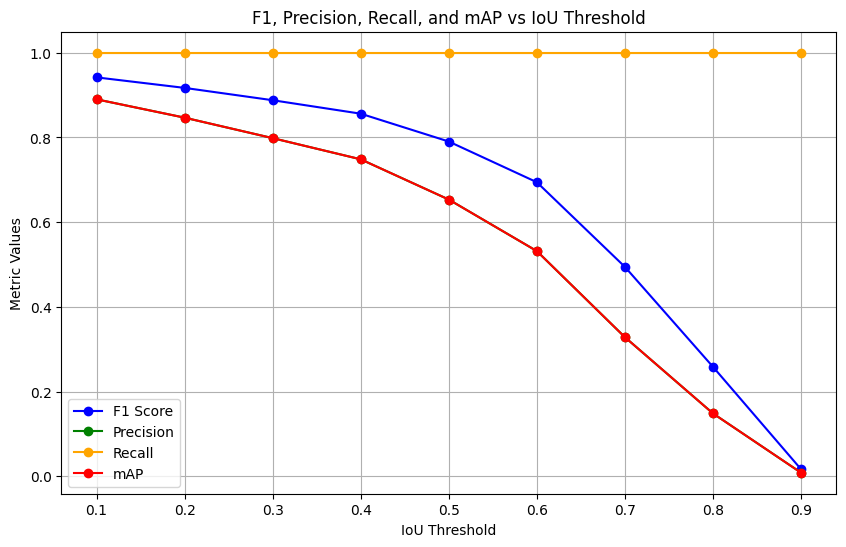

In [102]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, test_loader = fetch_dataloader()

network = ObjectDetectionNetwork(backbone=customResNet()).to(device)

optimizer = optim.Adam(network.parameters(), lr=0.001)

loss_fn = {
    "cls_loss_fn": nn.CrossEntropyLoss(),  
    "reg_loss_fn": nn.MSELoss()  
}

print("Training ObjectDetectionNetwork...")
network, train_data = train(
    network, optimizer, loss_fn, train_loader, epochs=250, verbose=True, device=device
)

save_model(network, "ObjectDetectionNetwork")

accuracy, _, results = evalf(network, test_loader, device=device, loss_fn=loss_fn)
print(f"Final Accuracy: {accuracy:.5f}")

predictions = results[0]
ground_truths = results[1]

predictions, ground_truths = convert_bboxes(predictions, ground_truths, 32, 32)
# Evaluate
res = evaluate(predictions, ground_truths, iou_threshold=0.5)
print("Evaluation Results:")
print(res)

plot_metrics_curves(predictions, ground_truths)
